# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# The Goal
- Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. 

# 1 Data Explore and Visualization
In this part, I will have a general look at the imported data. Try to answer these questions:
- what are the dimensions of the datasets?
- what features does each of them have?
- what's the value range / value type of each feature?

By answering these questions, i will have an idea of what resources I can use to solve the problem.

## 1.1 Portfolio Dataset

In [4]:
portfolio.shape

(10, 6)

In [5]:
# This dataset is not big, so i will print all of it.
portfolio.sort_values(by=['offer_type'], inplace=True)


In [6]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


In [7]:
portfolio.groupby('offer_type').describe(percentiles=[])

difficulty                                   duration       \
                   count   mean       std  min   50%   max    count mean   
offer_type                                                                 
bogo                 4.0   7.50  2.886751  5.0   7.5  10.0      4.0  6.0   
discount             4.0  11.75  5.678908  7.0  10.0  20.0      4.0  8.5   
informational        2.0   0.00  0.000000  0.0   0.0   0.0      2.0  3.5   

                                        reward                                 
                    std  min  50%   max  count mean       std  min  50%   max  
offer_type                                                                     
bogo           1.154701  5.0  6.0   7.0    4.0  7.5  2.886751  5.0  7.5  10.0  
discount       1.732051  7.0  8.5  10.0    4.0  3.0  1.414214  2.0  2.5   5.0  
informational  0.707107  3.0  3.5   4.0    2.0  0.0  0.000000  0.0  0.0   0.0

There are three groups of offer type. Each offer has a very long offer id. For the convenience of interpretation, later i'll have to rename them. Each offer has different channels to spread, influence durations, difficulty and reward. 

From the describe table above, one can see that the "bogo" offers has lower difficulty and higher reward, but shorter duration compared with the "discount" offers. Informational offer has no certain difficulty or reward, the duration is smaller than the other two kinds of offers.

## 1.2 Profile Dataset

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile_clean = profile.copy()

In [11]:
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'].astype('str'), format='%Y%m%d')
today = datetime.datetime(2020, 4, 23)
profile_clean['member_days'] = (today - profile_clean['became_member_on']).dt.days

In [12]:
profile_clean.describe()

,age,income,member_days
count,17000.000000,14825.000000,17000.000000
mean,62.531412,65404.991568,1154.449882
std,26.738580,21598.299410,411.223904
min,18.000000,30000.000000,637.000000
25%,45.000000,49000.000000,845.000000
50%,58.000000,64000.000000,995.000000
75%,73.000000,80000.000000,1428.000000
max,118.000000,120000.000000,2460.000000


In [13]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

I notice there are a few abnormalities (age 118) and some missing data. I hope they are not a big percentage in my dataset. And it is very strange to see our third quartile of age is 73. Maybe this has something to do with our age abnormalities. I will look at this describe table again after i remove the abnormalities.

In [14]:
np.sum(profile.isnull())

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
np.sum(profile.isnull())/profile.shape[0]

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

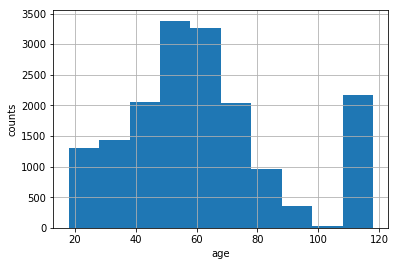

In [16]:
ax = profile['age'].hist()
ax.set_xlabel("age")
ax.set_ylabel("counts");

In [17]:
np.sum(profile['age'] == 118)

2175

In [18]:
age_mask = profile['age'] == 118
gender_mask = profile['gender'].isnull()
income_mask = profile['income'].isnull()

In [19]:
profile[age_mask & gender_mask & income_mask].shape

(2175, 5)

In [20]:
profile_clean = profile_clean.dropna()

In [21]:
profile_clean.shape

(14825, 6)

In [22]:
profile_clean.describe()

,age,income,member_days
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1159.478988
std,17.383705,21598.299410,419.205158
min,18.000000,30000.000000,637.000000
25%,42.000000,49000.000000,845.000000
50%,55.000000,64000.000000,995.000000
75%,66.000000,80000.000000,1434.000000
max,101.000000,120000.000000,2460.000000


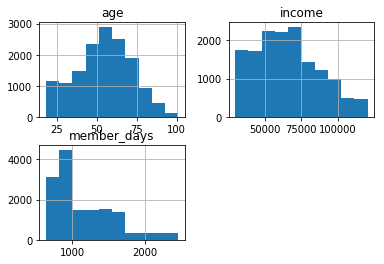

In [23]:
profile_clean.hist();

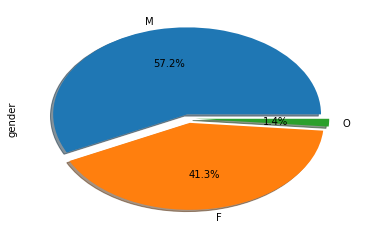

In [24]:
profile_clean['gender'].value_counts().plot.pie(explode = (0.05, 0.05, 0.05), autopct='%1.1f%%', shadow=True);

The distribution of age is most close to normalized distribution, the income and days since a member are all a bit skewed. 

The gender piechart shows that the male-female ratio is neutral (close to 50%).

Draw correlation chart to see if these features are related. The member_days are not related with age or income, age and income are a bit correlated, with is understandable, but the value is not very high (0.31).

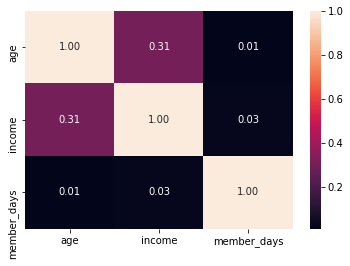

In [25]:
sns.heatmap(profile_clean.corr(), annot=True, fmt='.2f');

## 1.3 Transcript Dataset

In [26]:
transcript.shape

(306534, 4)

In [27]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [28]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [29]:
np.sum(transcript.isnull())

event     0
person    0
time      0
value     0
dtype: int64

In [30]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
transcript['event'].value_counts().values

array([138953,  76277,  57725,  33579])

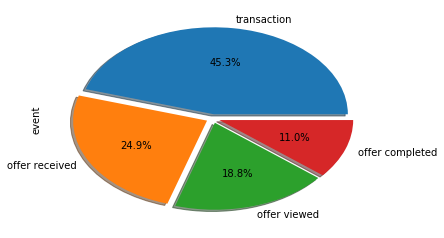

In [32]:
transcript['event'].value_counts().plot.pie(explode = (0.05, 0.05, 0.05, 0.05), autopct='%1.1f%%', shadow=True)

**Are the offers equaly sent?**

I plot the amount of offer sent for each offer type (as follows). Each offer has been sent in similar times. 

In [33]:
# Let's have a look at the values
# this step runs too long
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

There are a big variance on the column "value", mainly due to different size of the transaction. And column "value" is dependent on type of "event". 

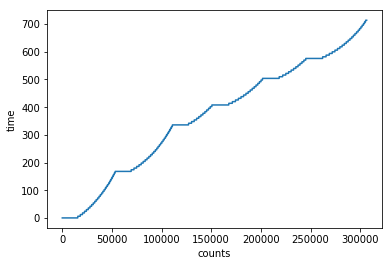

In [34]:
ax = transcript['time'].plot()
ax.set_xlabel("counts")
ax.set_ylabel("time");

By plotting the column "time", we can see that the transcript dataset is orgnized according to the increasing of time. While maximum of time is 714 hours, it gives us the time window of 30 days (714/24) of this observation. 

I want to have a look how the company is sending the promotion infos, mainly the frequency, do they send it every hour, or every few days?

In [36]:
ser_sending = transcript[transcript['event'] == 'offer received']['time'].value_counts().sort_index()
print(ser_sending)

0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
Name: time, dtype: int64


Good. Now we can see, that Starbuck has send 6 times the promotions. Each time around 12K sendings, but not in a constant period. I would like to same this sending event as a dataframe.

In [37]:
df_sending = ser_sending.reset_index() 
df_sending.columns = ['sent_time','sent_cnt']
print(df_sending)

   sent_time  sent_cnt
0          0     12650
1        168     12669
2        336     12711
3        408     12778
4        504     12704
5        576     12765


I'm also curious about to each customer get how many times of promotion messages.

In [38]:
ser_sendto = transcript[transcript['event'] == 'offer received'].groupby('person')['event'].value_counts()

In [39]:
ser_sendto.describe()

count    16994.000000
mean         4.488467
std          1.073047
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: event, dtype: float64

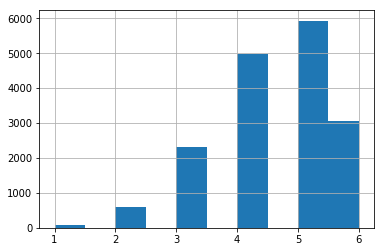

In [40]:
ser_sendto.hist()

So each person get a maximum 6 and minimum 1 promotions. But the count of people who received promotions is 16994, smaller than our profile data dimension (17000), seems like there are a few people in our profile dataset didn't get any promotion data. These profile data will not be included in our final dataset.

At last, I want to look at the relationship between event, value and time for one customer. I'll try to pick one or few customer that can represent common scenarios. In the next section, i will combine the observations from three datasets and define problem to solve.

In [41]:
transcript[transcript['person'] ==transcript['person'][0]]

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [42]:
transcript[transcript['person'] ==transcript['person'][1]]

,event,person,time,value
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15562,offer viewed,a03223e636434f42ac4c3df47e8bac43,6,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
90553,transaction,a03223e636434f42ac4c3df47e8bac43,234,{'amount': 1.09}
97700,transaction,a03223e636434f42ac4c3df47e8bac43,264,{'amount': 3.5}
110829,offer received,a03223e636434f42ac4c3df47e8bac43,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
123539,offer viewed,a03223e636434f42ac4c3df47e8bac43,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
150599,offer received,a03223e636434f42ac4c3df47e8bac43,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
201573,offer received,a03223e636434f42ac4c3df47e8bac43,504,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
245125,offer received,a03223e636434f42ac4c3df47e8bac43,576,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
277104,transaction,a03223e636434f42ac4c3df47e8bac43,612,{'amount': 0.06}


In [43]:
transcript[transcript['person'] ==transcript['person'][2]]

,event,person,time,value
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
20283,offer viewed,e2127556f4f64592b11af22de27a7932,18,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
102635,transaction,e2127556f4f64592b11af22de27a7932,288,{'amount': 17.88}
103834,transaction,e2127556f4f64592b11af22de27a7932,294,{'amount': 21.43}
110830,offer received,e2127556f4f64592b11af22de27a7932,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
150600,offer received,e2127556f4f64592b11af22de27a7932,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
171209,offer viewed,e2127556f4f64592b11af22de27a7932,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
201574,offer received,e2127556f4f64592b11af22de27a7932,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
225059,offer viewed,e2127556f4f64592b11af22de27a7932,522,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
225060,transaction,e2127556f4f64592b11af22de27a7932,522,{'amount': 18.42}


## 1.4 Data Analysis and Approach to Solution

From the data explore, I can see four binary classificaiton:
1. who will be the target customer of bogo?
2. who will be the target customer of discount?
3. who will be the target of infomational ads?
4. who will or will not check the offers been sent?

Since the goal of this project is: "To determine which demographic groups respond best to which offer type", i will work on the first three questions. 

First need to define what is a correct match between customer and offer type. The promotion start from event "offer received". The result of each promotion will be evaluated by:
```
A transaction followed by offer receive, offer viewed, and offer completed (completed not required for informational offer). As shown following:
    - received -> viewed -> transaction -> completed 
    - received -> viewed -> transaction (informational)
    - for info offer, the time period between offer receive and transaction shall be shorter than the duration of the offer.
    

```

Any "offer received" event that fulfils these conditions, will be labeled as "positive". Those got viewed but no valid transaction followed belong to the "negative" group. The offers not got viewed cannot be labeled, thus will be exclued from the training or test.

Note that there are fewer "offer complete" than "offer received" (less than half). When I label these two kinds of offers, i will start from the completed offer. 

# 2. Data Preprocessing

## 2.1 Merge all the data together

In [44]:
# merge the data to one big data frame
# first need to change each dataset a little so that they can merge. The data is already prepared by explore process,
# with date became a member changed to days, and NaNs dropped.
# profile_clean
profile_clean = profile.copy()
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'].astype('str'), format='%Y%m%d')
today = datetime.datetime(2020, 4, 23)
profile_clean['member_days'] = (today - profile_clean['became_member_on']).dt.days
profile_clean.drop('became_member_on', axis=1, inplace = True)
profile_clean = profile_clean.dropna()

# transcript: splite value dict to three columns: offer id, amount, offer reward. 
# Offer reward is the same with the reward in portfolio dataset, can also be dropout.
df_split = transcript['value'].apply(pd.Series)
df_split['offer id'] = df_split['offer id'].fillna(df_split['offer_id'])
df_split.drop(['offer_id', 'reward'],axis=1, inplace = True)
# drop 'value' column, contact df_split
transcript_clean = pd.concat([transcript, df_split], axis = 1, join = 'inner')
transcript_clean.drop('value',axis=1, inplace = True)

# portfolio: deal with the channels
channels_set = {'email', 'mobile', 'social', 'web'}
portfolio_clean = portfolio.copy()
for i in channels_set:
    portfolio_clean[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

portfolio_clean.drop('channels', axis=1, inplace=True)


In [45]:
# merge transcript_clean with profile_clean
merged_data_df1 = pd.merge(transcript_clean, profile_clean, left_on = 'person', right_on='id')
merged_data_df1.drop('id', axis=1, inplace=True)
# further merge with portfolio
merged_data_df = pd.merge(merged_data_df1, portfolio_clean, left_on = 'offer id', right_on='id', how='outer')
merged_data_df.drop('id',axis=1, inplace=True)

print('Dimension of transcript_clean:', transcript_clean.shape)
print('Dimension after merge with custumer profile:', merged_data_df1.shape)
print('Dimension after merge with offer portfolio :', merged_data_df.shape)

Dimension of transcript_clean: (306534, 5)
Dimension after merge with custumer profile: (272762, 9)
Dimension after merge with offer portfolio : (272762, 17)


In [46]:
# get transaction data
mask_transaction = merged_data_df['event'] == 'transaction'
transaction = merged_data_df.loc[mask_transaction]
transaction = transaction.loc[:, ['person', 'time','amount']]

# get offer data
mask_offer = merged_data_df['event'] != 'transaction'
offer = merged_data_df.loc[mask_offer]
offer.drop('amount', axis=1, inplace=True)

## 2.2 Label the Data
The beginning of the promotion process is sending the offers. The offers has been sent 6 times, each time to around 12k costumer. Apart from the offers sent to costumers we lack informations, the rest is my whole data set to train and test on. 

In this section, i will label the data according to the approach I described in chapter 1.4.


In [47]:
# create a few mask for data selection
mask_viewed = offer['event'] == 'offer viewed'
mask_received = offer['event'] == 'offer received'
mask_completed = offer['event'] == 'offer completed'

mask_bogo = offer['offer_type'] == 'bogo'
mask_disc = offer['offer_type'] == 'discount'
mask_info = offer['offer_type'] == 'informational'

# create a universe

universe_bogo = offer[mask_bogo]
universe_disc = offer[mask_disc]
universe_info = offer[mask_info]

In [53]:
# exclude some data
def exclude_data(df):
    req1 = req1 = df.shift(1).loc[mask_viewed]['event'] == 'offer completed'
    req2 = df.shift(1).loc[mask_viewed]['offer id'] == df.loc[mask_viewed]['offer id']
    req3 = df.shift(1).loc[mask_viewed]['person'] == df.loc[mask_viewed]['person']
    return (req1 & req2 & req3)

df_bogo_filter = exclude_data(universe_bogo)
df_bogo_filter = df_bogo_filter[df_bogo_filter==True]
universe_bogo = universe_bogo.drop(df_bogo_filter.index, axis=0)
df_bogo = universe_bogo.loc[mask_viewed].copy()

df_disc_filter = exclude_data(universe_disc)
df_disc_filter = df_disc_filter[df_disc_filter==True]
universe_disc = universe_disc.drop(df_disc_filter.index, axis=0)
df_disc = universe_disc.loc[mask_viewed].copy()

universe_info = offer.loc[mask_info]
df_info = universe_info[universe_info['event'] == 'offer viewed'].copy()

print('universe_bogo:\n',universe_bogo['event'].value_counts())
print('\nuniverse_disc:\n',universe_disc['event'].value_counts())
print('\nuniverse_info:\n',universe_info['event'].value_counts())

print('\nsize of bogo, disc, info datasets are:',df_bogo.shape, df_disc.shape, df_info.shape)

universe_bogo:
 offer received     26537
offer viewed       19763
offer completed    15258
Name: event, dtype: int64

universe_disc:
 offer received     26664
offer completed    17186
offer viewed       16585
Name: event, dtype: int64

universe_info:
 offer received    13300
offer viewed       9360
Name: event, dtype: int64

size of bogo, disc, info datasets are: (19763, 16) (16585, 16) (9360, 16)


df_bogo, df_disc, df_info contains all offers that have been viewed. I will further label them in combination with transaction data. 
1. followed the order offer received, viewed, complete (info type don't need complete)
2. a valid transaction (in valid time window, for bogo and discount amount shall higher than the difficulty)
3. not a transaction due to other bogo or discount 

In [54]:
# add lable column
df_bogo.loc[:, 'label'] = 0
df_disc.loc[:, 'label'] = 0
df_info.loc[:, 'label'] = 0

In [55]:
ser_sending.index.tolist()

[0, 168, 336, 408, 504, 576]

In [56]:
# what if there is a mismatch between small categories 
def max_sending_counts(df):
    query_sample = ''
    max_sending = 0
    sending_timestamp = ser_sending.index.tolist()
    for i in sending_timestamp:
        query_sample ='time == {}'.format(i)
        loc_max = df.query(query_sample).groupby('person')['offer_type'].count().max()
        if loc_max > max_sending:
            max_sending = loc_max

    return max_sending

print(max_sending_counts(universe_bogo.loc[mask_received]))
print(max_sending_counts(universe_disc.loc[mask_received]))
print(max_sending_counts(universe_info.loc[mask_received]))

1
1
1


The function max_sending_counts shows the maximum number of offer types each person get per sending round. The system sends each round only one offer to one customer. But one offer could be valid for longer time (maximum to 20 days). So one customer could deal with more than offer at one time point. 

In [57]:
# for bogo and discount, validation need to check the order of offer viewed and completed
def valid_offer_order(df):
    req1 = df.shift(-1).loc[mask_viewed]['event'] == 'offer completed'
    req2 = df.shift(-1).loc[mask_viewed]['offer id'] == df.loc[mask_viewed]['offer id']
    req3 = df.shift(-1).loc[mask_viewed]['person'] == df.loc[mask_viewed]['person']
 
    return req1 & req2 & req3

df_bogo.loc[:, 'label'] = valid_offer_order(universe_bogo)
df_disc.loc[:, 'label'] = valid_offer_order(universe_disc)

print(df_bogo['label'].value_counts())
print(df_disc['label'].value_counts())

True     10647
False     9116
Name: label, dtype: int64
True     11687
False     4898
Name: label, dtype: int64


In [58]:
# remove the transaction record due to bogo and discount, for info offers successfulness analysis
trans_info = transcript_clean.copy()

trans = transcript_clean[(transcript_clean.shift(-1)['event']=='offer completed')
                          & (transcript_clean['event'] == 'transaction')
                          & (transcript_clean.shift(-1)['time'] == transcript_clean['time'])
                          & (transcript_clean.shift(-1)['person'] == transcript_clean['person'])]

trans_info = trans_info.drop(trans.index)
trans_info = trans_info[trans_info['event']=='transaction']

In [59]:
# add time validation for each offer viewed
df_info_valid = df_info.copy()
ser_time = universe_info[universe_info.shift(-1)['event'] == 'offer viewed']['time']
ser_time.index +=1
df_info_valid['time_val'] = ser_time + df_info_valid ['duration']*24

In [60]:
# Lable Info Ads
def valid_info(row):
    t = trans_info[trans_info['person'] == row['person']]['time'] 
    for i in t:
        if  row['time'] <= i < row['time_val']:
            return True
        
    return False


df_info['label'] = df_info_valid[['person','time','time_val']].apply(lambda row: valid_info(row), axis=1)
df_info_valid['label'].value_counts()

0    9360
Name: label, dtype: int64

## 2.3 Implementation

In [61]:
def prepare_input(df):
    
    ml_df = df.copy()
    
    # feat engineering
    
    # make sure all columns are numeric
    ml_df = pd.concat([ml_df, pd.get_dummies(ml_df['gender'])], axis=1)
    ml_df = ml_df.drop(columns = ['event', 'person','offer id','offer_type', 'gender'])
    
    # encode targets as 0s 1s
    ml_df['label'] = ml_df['label'].astype(int)
    
    # split into feats and targets 
    target = ml_df['label']
    feats = ml_df.drop(columns=['label'], axis=1)

    # do train test split
    X_train, X_test, y_train, y_test = train_test_split(feats, target, 
                                                        shuffle = True, 
                                                        random_state=42, 
                                                        train_size  = 0.8)
        

    # normalize data (training data)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # normalize also test data, with statistics from train data
    X_test = scaler.transform(X_test)
#     print(X_train[:5])
    return X_train, X_test, y_train, y_test
    
    
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    
    eval_matrix ={}
#   results = {}
    model = model.fit(X_train, y_train)
    
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)

    # calculate evaluate paremeters
    mse_train = mean_squared_error(y_train, preds_train)
    mse_test = mean_squared_error(y_test, preds_test)
    precision, recall, f1score, _ = precision_recall_fscore_support(y_test, preds_test, average='macro')
    # add f1 score
    # precion and recall
  
    eval_matrix = {
        'accuracy_train':accuracy_train,
        'accuracy_test':accuracy_test,
        'precision':precision,
        'recall':recall,
        'f1score':f1score
    }
    return eval_matrix

#     results['accuracy_train'] = accuracy_train
#     results['accuracy_test'] = accuracy_test
#     results['mse_train'] = mse_train
#     results['mse_test'] = mse_test


In [62]:
def train_func(df):
    model_list=[]
    # init models
    model_lre = LogisticRegression(max_iter=100)
    model_tree  = DecisionTreeClassifier(criterion='entropy', max_depth = 6, min_samples_split = 90,
                                            min_samples_leaf = 50, random_state = 10)
    model_rf = RandomForestClassifier(n_estimators = 20, criterion='entropy', max_depth = 11, max_features= 'auto',
                                           min_samples_split = 10, min_samples_leaf = 20, random_state = 2)
    # model_ = SVC(C = 2.0, kernel = 'rbf', gamma = 'auto')


    X_train, X_test, y_train, y_test = prepare_input(df)
    
    eval_matrix_lre = train_evaluate_model(model_lre, X_train, y_train, X_test, y_test)
    eval_matrix_tree = train_evaluate_model(model_tree, X_train, y_train, X_test, y_test)
    eval_matrix_rf = train_evaluate_model(model_rf, X_train, y_train, X_test, y_test)
    res = pd.concat([pd.Series(eval_matrix_lre, name = 'lre'),
                    pd.Series(eval_matrix_tree, name = 'tree'), 
                    pd.Series(eval_matrix_rf, name = 'rf')], 
                    axis = 1)
    
    model_list.append(model_lre)
    model_list.append(model_tree)
    model_list.append(model_rf)

    
    return res, model_list
    

In [63]:
res_bogo, model_list_bogo = train_func(df_bogo)
res_bogo

,lre,tree,rf
accuracy_train,0.666350,0.725047,0.752056
accuracy_test,0.665570,0.712370,0.721730
precision,0.664999,0.711626,0.721210
recall,0.662769,0.711148,0.720055
f1score,0.662913,0.711324,0.720377


In [64]:
res_disc, model_list_disc = train_func(df_disc)
res_disc

,lre,tree,rf
accuracy_train,0.736886,0.748191,0.775927
accuracy_test,0.730479,0.739524,0.744347
precision,0.680304,0.689063,0.696038
recall,0.602503,0.633326,0.642504
f1score,0.606668,0.643575,0.653708


In [65]:
res_info, model_list_info = train_func(df_info)
res_info

,lre,tree,rf
accuracy_train,0.606838,0.669872,0.704861
accuracy_test,0.625000,0.650641,0.655983
precision,0.625204,0.651824,0.655824
recall,0.625245,0.651403,0.655391
f1score,0.624993,0.650539,0.655415


## 2.4 Refinement
### 2.4.1 Add the frequency of transaction as features

In [66]:
df_trans_freq = pd.DataFrame(transcript_clean['person'].value_counts()).reset_index()
df_trans_freq = df_trans_freq.rename(columns={'person':'freq'})

df_bogo_feature = pd.merge(left= df_bogo, 
                           right = df_trans_freq, 
                           how = 'inner', 
                           left_on = 'person', 
                           right_on = 'index').drop('index',axis=1)
df_disc_feature = pd.merge(left= df_disc, 
                           right = df_trans_freq, 
                           how = 'inner', 
                           left_on = 'person', 
                           right_on = 'index').drop('index',axis=1)
df_info_feature = pd.merge(left= df_info, 
                           right = df_trans_freq, 
                           how = 'inner', 
                           left_on = 'person', 
                           right_on = 'index').drop('index',axis=1)

In [67]:
res_bogo, model_bogo = train_func(df_bogo_feature)
res_bogo

,lre,tree,rf
accuracy_train,0.730108,0.765022,0.798798
accuracy_test,0.728814,0.756641,0.769036
precision,0.727886,0.757690,0.769150
recall,0.724521,0.751280,0.764814
f1score,0.725396,0.752635,0.766004


In [68]:
res_disc, model_disc = train_func(df_disc_feature)
res_disc

,lre,tree,rf
accuracy_train,0.825068,0.831776,0.843307
accuracy_test,0.805547,0.817606,0.817305
precision,0.772726,0.784334,0.788318
recall,0.740921,0.766893,0.755763
f1score,0.753168,0.774518,0.768500


In [69]:
res_info, model_info = train_func(df_info_feature)
res_info

,lre,tree,rf
accuracy_train,0.666800,0.697249,0.732105
accuracy_test,0.646368,0.642094,0.670940
precision,0.648059,0.642619,0.670319
recall,0.647931,0.642862,0.670441
f1score,0.646361,0.642035,0.670368


### 2.4.2 Add the total amount of money each customer spent during these 30 days 

In [70]:
df_trans_amount = transcript_clean.groupby('person')['amount'].sum().reset_index()
df_trans_amount = df_trans_amount.rename(columns={'amount':'total_amount'})

df_bogo_feature = pd.merge(left= df_bogo_feature, 
                           right = df_trans_amount, 
                           how = 'inner', 
                           left_on = 'person', 
                           right_on = 'person')#.drop('index',axis=1)
df_disc_feature = pd.merge(left= df_disc_feature, 
                           right = df_trans_amount, 
                           how = 'inner', 
                           left_on = 'person', 
                           right_on = 'person')#.drop('index',axis=1)
df_info_feature = pd.merge(left= df_info_feature, 
                           right = df_trans_amount, 
                           how = 'inner', 
                           left_on = 'person', 
                           right_on = 'person')#.drop('index',axis=1)

In [71]:
res_bogo, model_bogo = train_func(df_bogo_feature)
res_bogo

,lre,tree,rf
accuracy_train,0.804048,0.831626,0.846110
accuracy_test,0.812041,0.824184,0.826714
precision,0.811393,0.825261,0.827464
recall,0.813214,0.820506,0.823332
f1score,0.811588,0.821979,0.824678


In [72]:
res_disc, model_disc = train_func(df_disc_feature)
res_disc

,lre,tree,rf
accuracy_train,0.843006,0.850995,0.863958
accuracy_test,0.829665,0.826952,0.836599
precision,0.798965,0.810927,0.816625
recall,0.783425,0.754059,0.775663
f1score,0.790378,0.773358,0.791327


In [73]:
res_info, model_info = train_func(df_info_feature)
res_info

,lre,tree,rf
accuracy_train,0.668937,0.697115,0.749065
accuracy_test,0.647436,0.655449,0.675214
precision,0.648727,0.660232,0.674472
recall,0.648756,0.658433,0.674281
f1score,0.647435,0.655033,0.674357


# 3. Model Evaluation and Validation


In [74]:
featcol = ['time', 'age', 'income', 'member_days', 
                    'difficulty', 'duration',  'reward', 
                    'mobile', 'web', 'social', 'email', 
                    'g_F','g_M','g_O']

#featcol = ['time', 'age', 'income','member_days', 
#                    'difficulty', 'duration',  'reward', 
#                    'mobile', 'web', 'social', 'email', 
#                    'g_F','g_M','g_O']

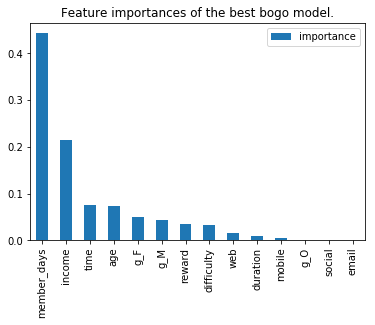

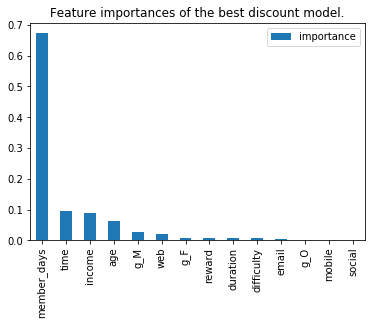

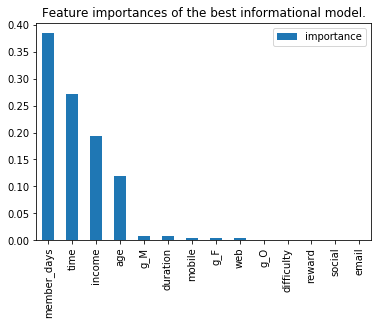

In [75]:
def read_and_plot_feature_importance(best_model, name=None):
    
    feat_importances = pd.DataFrame(best_model.feature_importances_,
                                    index = featcol,
                                    columns=['importance']).sort_values('importance',ascending=False)
    feat_importances.plot.bar()
    plt.title(f'Feature importances of the best {name} model.')
    plt.show()

read_and_plot_feature_importance(model_list_bogo[2], 'bogo')
read_and_plot_feature_importance(model_list_disc[2], 'discount')
read_and_plot_feature_importance(model_list_info[2], 'informational')